[Expt/trainable-forgetting-decay](https://github.com/open-spaced-repetition/fsrs-optimizer/tree/Expt/trainable-forgetting-decay)

In [1]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
    1,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    flattened_revlogs = []
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        request_retention=0.8,
        deck_size=30000,
        learn_span=learn_span,
        max_cost_perday=3600,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
        fuzz=True,
    )

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None

def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[19])
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 2567


  0%|          | 0/2567 [00:00<?, ?it/s]

loss before: 0.5311, loss after: 0.4909
RMSE(bins): 0.0384
AUC: 0.5906
1.1596 -> 1.3269: SMAPE=13.4567%
1.7974 -> 2.0038: SMAPE=10.8597%
13.1205 -> 9.6501: SMAPE=30.4814%
49.3729 -> 36.8189: SMAPE=29.1304%
7.2303 -> 7.3365: SMAPE=1.4581%
0.5081 -> 0.4558: SMAPE=10.8517%
1.5371 -> 1.5192: SMAPE=1.1714%
0.001 -> 0.0967: SMAPE=195.9058%
1.5052 -> 1.4125: SMAPE=6.3543%
0.1261 -> 0.3495: SMAPE=93.9445%
0.9735 -> 0.8939: SMAPE=8.5252%
1.8924 -> 1.844: SMAPE=2.5907%
0.1486 -> 0.1918: SMAPE=25.3819%
0.2407 -> 0.211: SMAPE=13.1503%
2.1937 -> 2.1844: SMAPE=0.4248%
0.1518 -> 0.1842: SMAPE=19.2857%
3.0699 -> 2.7716: SMAPE=10.2131%
1 -> 0.535: SMAPE=60.5863%
Avg. SMAPE: 29.6540%
loss before: 0.5311, loss after: 0.4927
RMSE(bins): 0.0421
AUC: 0.5836
--------------------------------
learn_span: 60


sample size: 7170


  0%|          | 0/7170 [00:00<?, ?it/s]

loss before: 0.5619, loss after: 0.5189
RMSE(bins): 0.0283
AUC: 0.5688
1.1596 -> 1.1212: SMAPE=3.3672%
1.7974 -> 1.9749: SMAPE=9.4107%
13.1205 -> 10.9457: SMAPE=18.0735%
49.3729 -> 47.0728: SMAPE=4.7697%
7.2303 -> 7.239: SMAPE=0.1203%
0.5081 -> 0.4439: SMAPE=13.4874%
1.5371 -> 1.6406: SMAPE=6.5141%
0.001 -> 0.0272: SMAPE=185.8156%
1.5052 -> 1.4351: SMAPE=4.7682%
0.1261 -> 0.2705: SMAPE=72.8190%
0.9735 -> 0.9431: SMAPE=3.1723%
1.8924 -> 1.8095: SMAPE=4.4788%
0.1486 -> 0.228: SMAPE=42.1668%
0.2407 -> 0.2367: SMAPE=1.6757%
2.1937 -> 2.2365: SMAPE=1.9322%
0.1518 -> 0.2223: SMAPE=37.6905%
3.0699 -> 2.9219: SMAPE=4.9401%
1 -> 0.3226: SMAPE=102.4346%
Avg. SMAPE: 28.7576%
loss before: 0.5619, loss after: 0.5198
RMSE(bins): 0.0303
AUC: 0.5666
--------------------------------
learn_span: 120


sample size: 16072


  0%|          | 0/16072 [00:00<?, ?it/s]

loss before: 0.5483, loss after: 0.5103
RMSE(bins): 0.0239
AUC: 0.5643
1.1596 -> 1.0943: SMAPE=5.7944%
1.7974 -> 1.8882: SMAPE=4.9273%
13.1205 -> 12.0965: SMAPE=8.1215%
49.3729 -> 29.5978: SMAPE=50.0821%
7.2303 -> 7.1279: SMAPE=1.4264%
0.5081 -> 0.2608: SMAPE=64.3257%
1.5371 -> 1.5375: SMAPE=0.0260%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.5514: SMAPE=3.0230%
0.1261 -> 0.1505: SMAPE=17.6428%
0.9735 -> 1.0702: SMAPE=9.4632%
1.8924 -> 1.8237: SMAPE=3.6974%
0.1486 -> 0.2066: SMAPE=32.6577%
0.2407 -> 0.234: SMAPE=2.8228%
2.1937 -> 2.3498: SMAPE=6.8714%
0.1518 -> 0.1544: SMAPE=1.6982%
3.0699 -> 2.6008: SMAPE=16.5447%
1 -> 0.4377: SMAPE=78.2222%
Avg. SMAPE: 17.0748%
loss before: 0.5483, loss after: 0.5108
RMSE(bins): 0.0245
AUC: 0.5616
--------------------------------
learn_span: 240


sample size: 35703


  0%|          | 0/35703 [00:00<?, ?it/s]

loss before: 0.5462, loss after: 0.5145
RMSE(bins): 0.0197
AUC: 0.5579
1.1596 -> 1.1404: SMAPE=1.6696%
1.7974 -> 1.8597: SMAPE=3.4071%
13.1205 -> 11.8819: SMAPE=9.9078%
49.3729 -> 44.9382: SMAPE=9.4044%
7.2303 -> 7.0972: SMAPE=1.8580%
0.5081 -> 0.331: SMAPE=42.2119%
1.5371 -> 1.7108: SMAPE=10.6961%
0.001 -> 0.0045: SMAPE=127.2727%
1.5052 -> 1.4815: SMAPE=1.5870%
0.1261 -> 0.1532: SMAPE=19.4057%
0.9735 -> 1.056: SMAPE=8.1301%
1.8924 -> 1.7383: SMAPE=8.4887%
0.1486 -> 0.2318: SMAPE=43.7434%
0.2407 -> 0.2758: SMAPE=13.5915%
2.1937 -> 2.302: SMAPE=4.8179%
0.1518 -> 0.1597: SMAPE=5.0722%
3.0699 -> 2.9968: SMAPE=2.4099%
1 -> 0.4376: SMAPE=78.2415%
Avg. SMAPE: 21.7731%
loss before: 0.5462, loss after: 0.5146
RMSE(bins): 0.0193
AUC: 0.5584
--------------------------------
learn_span: 480


sample size: 76099


  0%|          | 0/76099 [00:00<?, ?it/s]

loss before: 0.5427, loss after: 0.5166
RMSE(bins): 0.0144
AUC: 0.5537
1.1596 -> 1.149: SMAPE=0.9183%
1.7974 -> 1.6753: SMAPE=7.0320%
13.1205 -> 11.6675: SMAPE=11.7234%
49.3729 -> 45.8591: SMAPE=7.3795%
7.2303 -> 6.9151: SMAPE=4.4566%
0.5081 -> 0.4252: SMAPE=17.7649%
1.5371 -> 1.6768: SMAPE=8.6935%
0.001 -> 0.0036: SMAPE=113.0435%
1.5052 -> 1.3822: SMAPE=8.5198%
0.1261 -> 0.1252: SMAPE=0.7163%
0.9735 -> 1.0739: SMAPE=9.8076%
1.8924 -> 1.7301: SMAPE=8.9607%
0.1486 -> 0.2126: SMAPE=35.4374%
0.2407 -> 0.2612: SMAPE=8.1690%
2.1937 -> 2.4738: SMAPE=12.0021%
0.1518 -> 0.1434: SMAPE=5.6911%
3.0699 -> 3.0306: SMAPE=1.2884%
1 -> 0.4517: SMAPE=75.5390%
Avg. SMAPE: 18.7302%
loss before: 0.5427, loss after: 0.5166
RMSE(bins): 0.0141
AUC: 0.5547
--------------------------------
learn_span: 960


sample size: 160697


  0%|          | 0/160697 [00:00<?, ?it/s]

loss before: 0.5357, loss after: 0.5142
RMSE(bins): 0.0123
AUC: 0.5485
1.1596 -> 1.0817: SMAPE=6.9513%
1.7974 -> 1.5137: SMAPE=17.1363%
13.1205 -> 12.0291: SMAPE=8.6793%
49.3729 -> 47.435: SMAPE=4.0036%
7.2303 -> 6.7792: SMAPE=6.4399%
0.5081 -> 0.4667: SMAPE=8.4941%
1.5371 -> 1.5429: SMAPE=0.3766%
0.001 -> 0.0033: SMAPE=106.9767%
1.5052 -> 1.2389: SMAPE=19.4089%
0.1261 -> 0.132: SMAPE=4.5719%
0.9735 -> 1.1875: SMAPE=19.8056%
1.8924 -> 1.5234: SMAPE=21.6055%
0.1486 -> 0.2065: SMAPE=32.6105%
0.2407 -> 0.275: SMAPE=13.3023%
2.1937 -> 2.788: SMAPE=23.8593%
0.1518 -> 0.1568: SMAPE=3.2404%
3.0699 -> 3.0183: SMAPE=1.6951%
1 -> 0.5306: SMAPE=61.3354%
Avg. SMAPE: 20.0274%
loss before: 0.5357, loss after: 0.5141
RMSE(bins): 0.0110
AUC: 0.5494
--------------------------------
learn_span: 1920


sample size: 303843


  0%|          | 0/303843 [00:00<?, ?it/s]

loss before: 0.5339, loss after: 0.5156
RMSE(bins): 0.0094
AUC: 0.5485
1.1596 -> 1.0653: SMAPE=8.4768%
1.7974 -> 1.6815: SMAPE=6.6630%
13.1205 -> 12.4145: SMAPE=5.5297%
49.3729 -> 45.8657: SMAPE=7.3651%
7.2303 -> 6.4404: SMAPE=11.5561%
0.5081 -> 0.5035: SMAPE=0.9095%
1.5371 -> 1.5093: SMAPE=1.8251%
0.001 -> 0.0037: SMAPE=114.8936%
1.5052 -> 1.0257: SMAPE=37.8917%
0.1261 -> 0.1363: SMAPE=7.7744%
0.9735 -> 1.3387: SMAPE=31.5890%
1.8924 -> 1.5688: SMAPE=18.6987%
0.1486 -> 0.1672: SMAPE=11.7796%
0.2407 -> 0.2379: SMAPE=1.1701%
2.1937 -> 2.9646: SMAPE=29.8897%
0.1518 -> 0.1495: SMAPE=1.5267%
3.0699 -> 3.0594: SMAPE=0.3426%
1 -> 0.5323: SMAPE=61.0455%
Avg. SMAPE: 19.9404%
loss before: 0.5339, loss after: 0.5155
RMSE(bins): 0.0090
AUC: 0.5490
--------------------------------


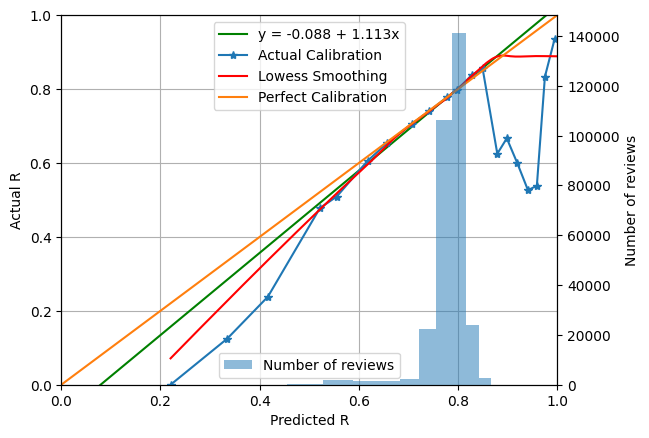

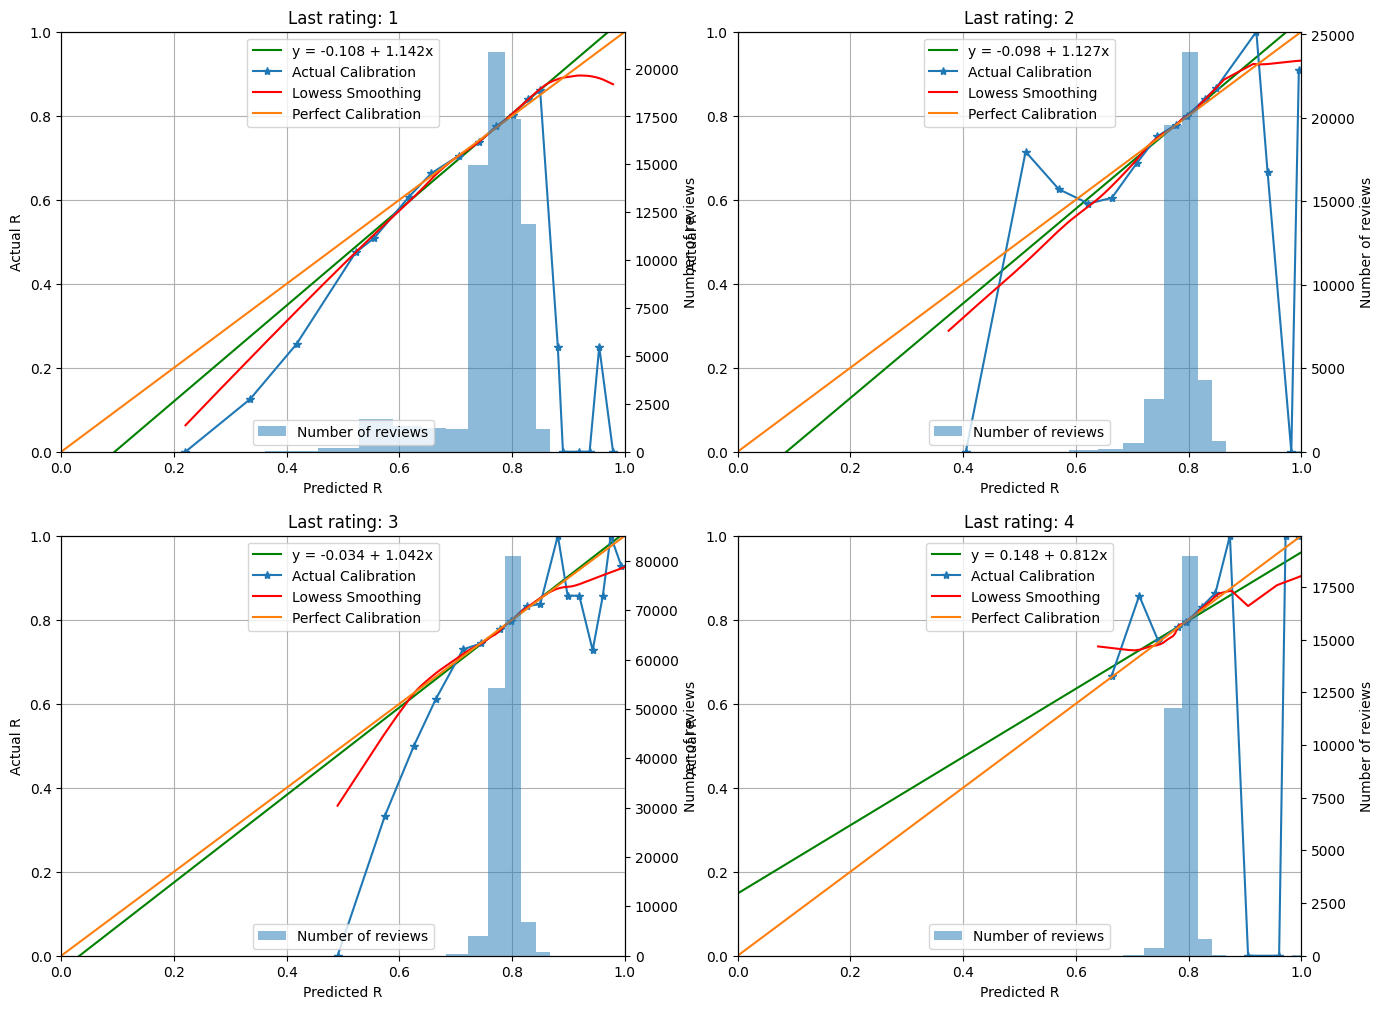

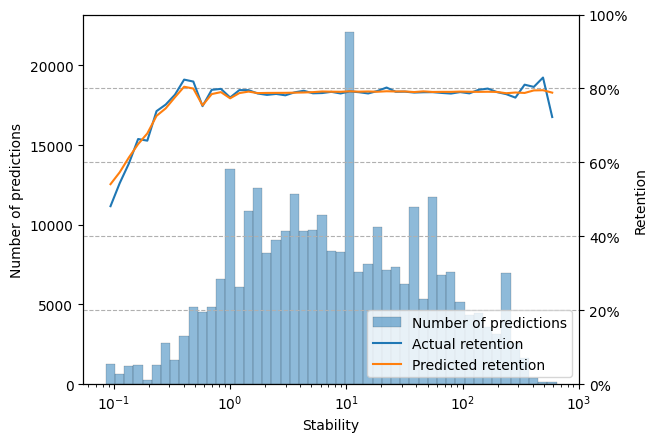

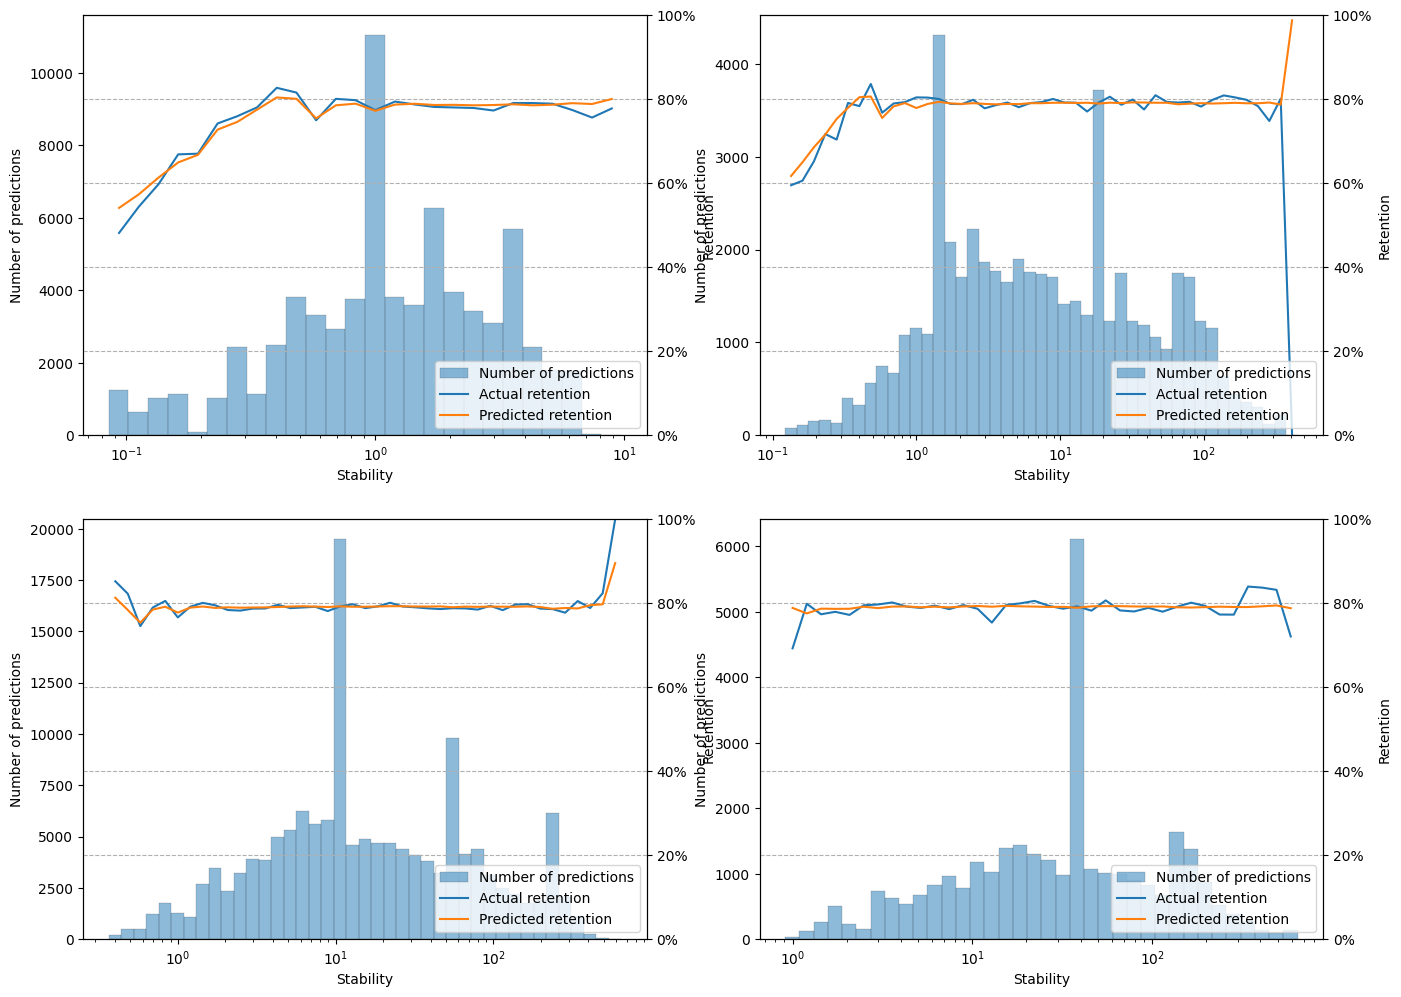

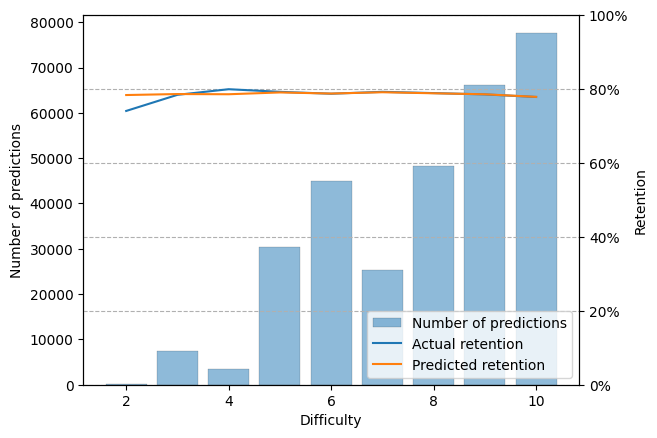

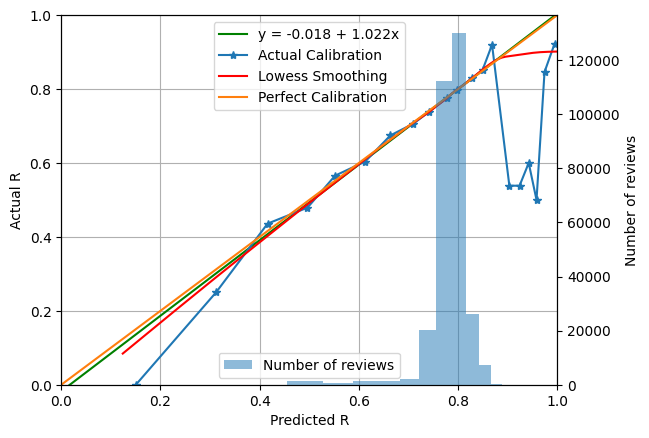

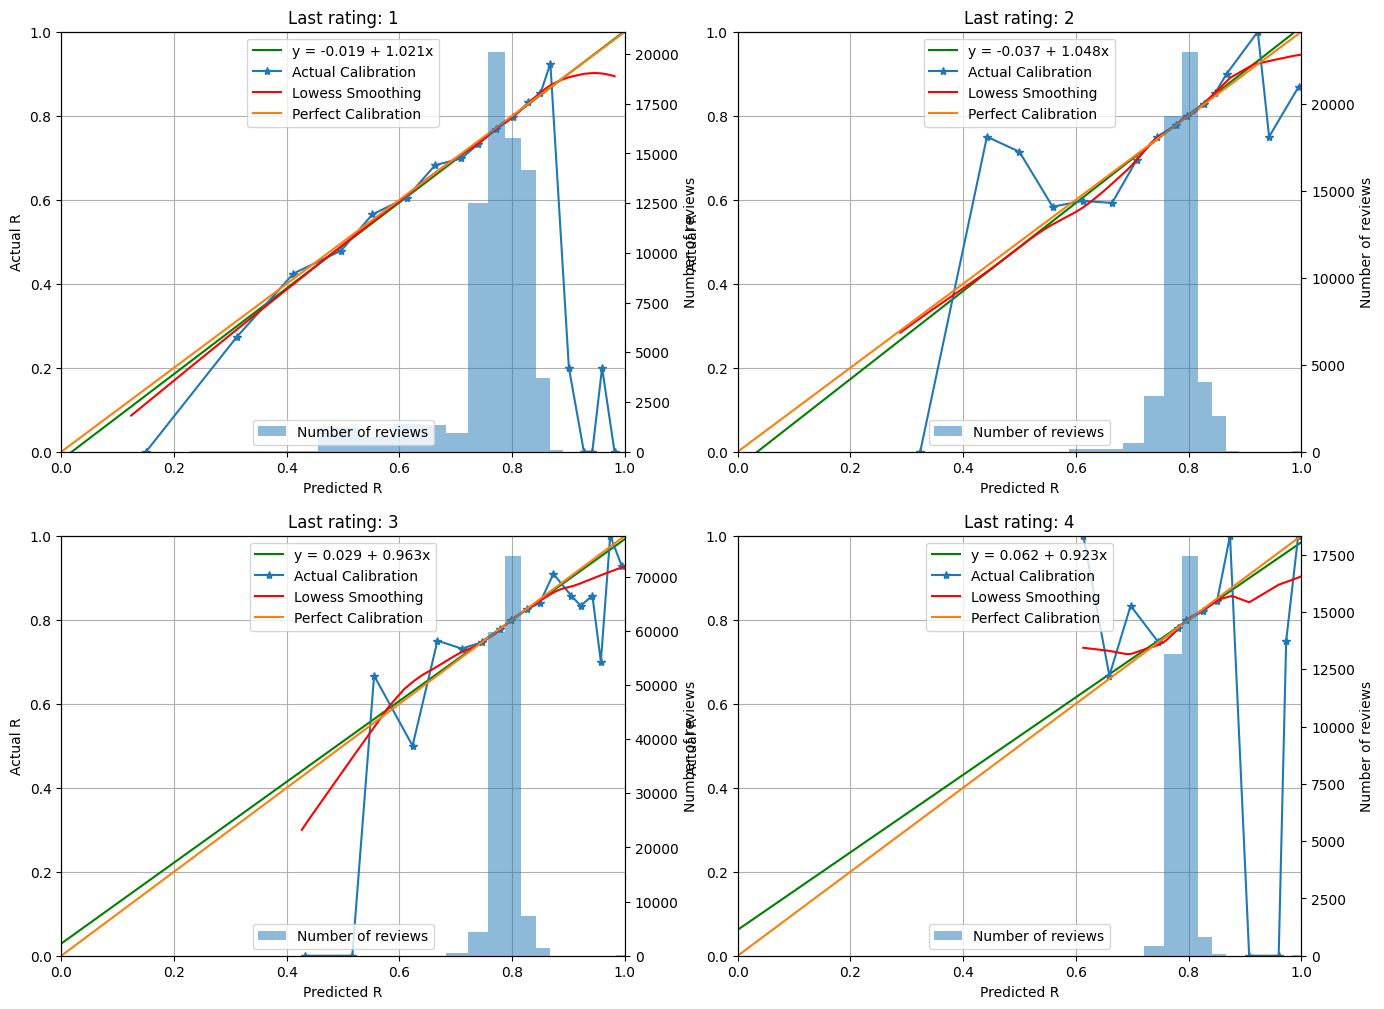

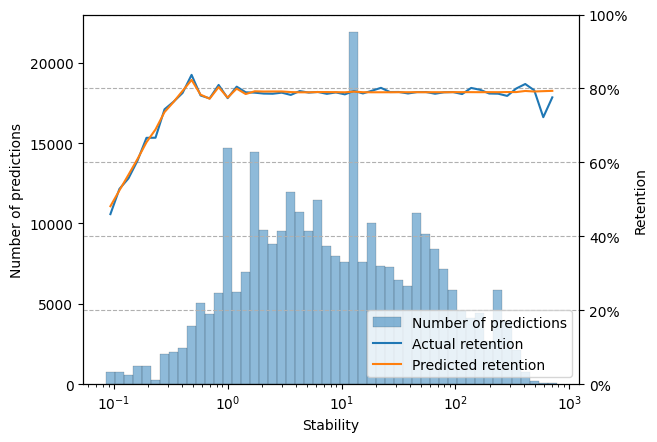

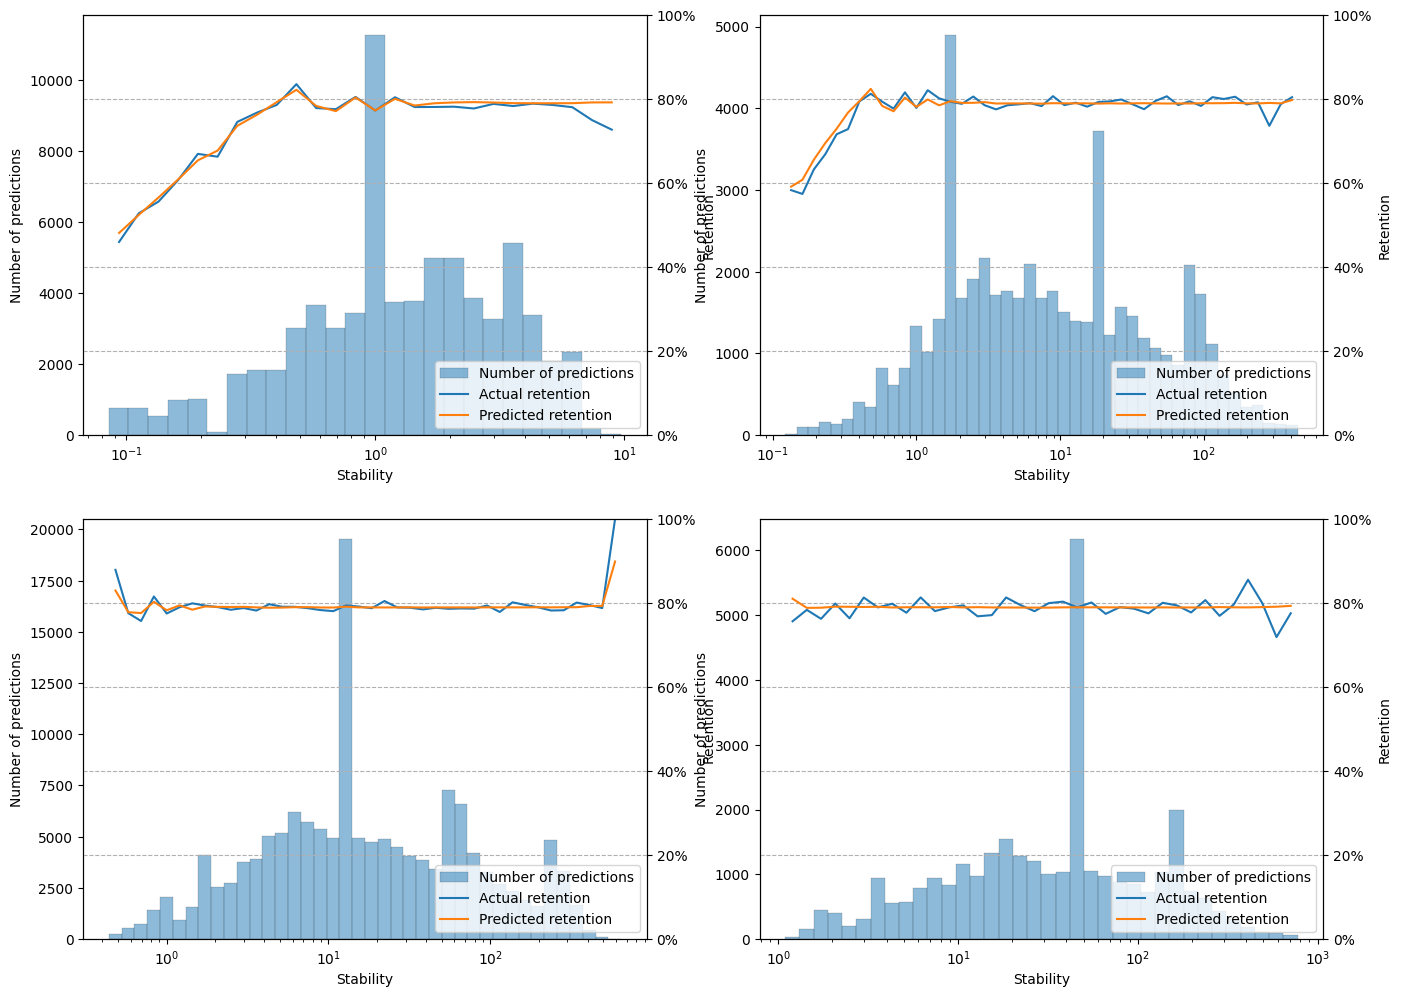

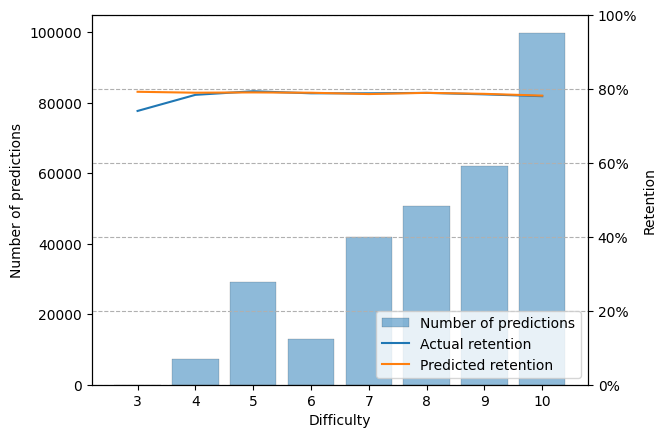

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

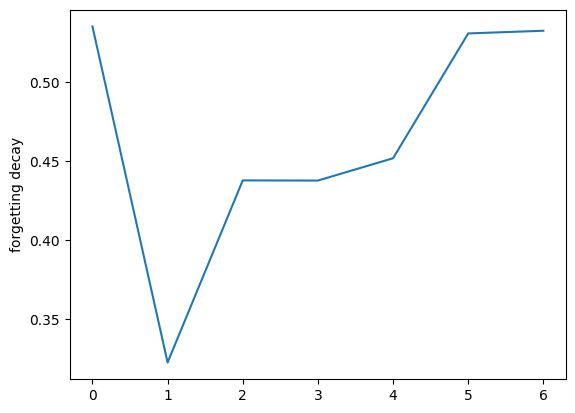

In [5]:
plt.plot(decay_list)
plt.ylabel("forgetting decay")
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}")
print(f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}")
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.001839 -0.000857 -0.000515 -0.000088 -0.000003  0.000076  0.000099]
RMSE(bins) (trained - ideal): [-0.003721 -0.001972 -0.000536  0.000477  0.000255  0.001206  0.000433]
AUC (trained - ideal): [ 0.007092  0.002255  0.002766 -0.000442 -0.001026 -0.000948 -0.000559]


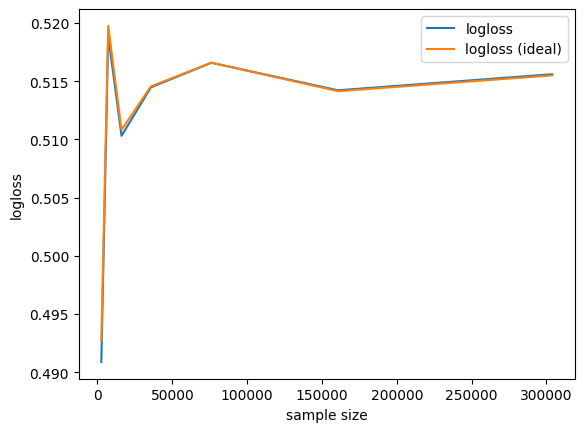

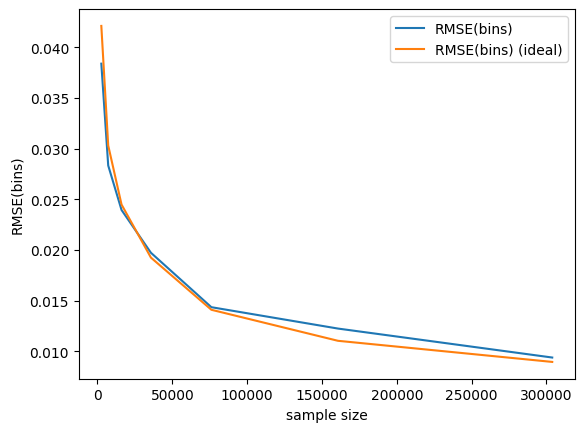

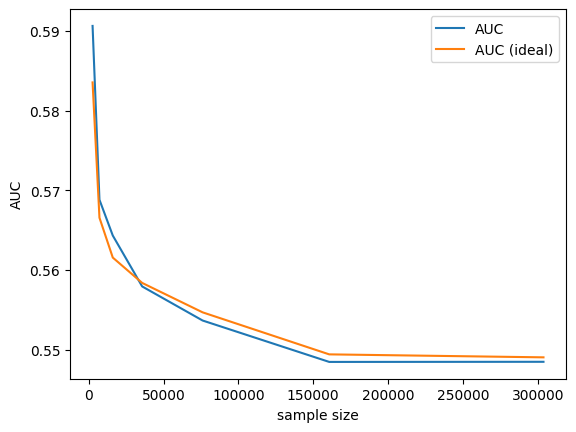

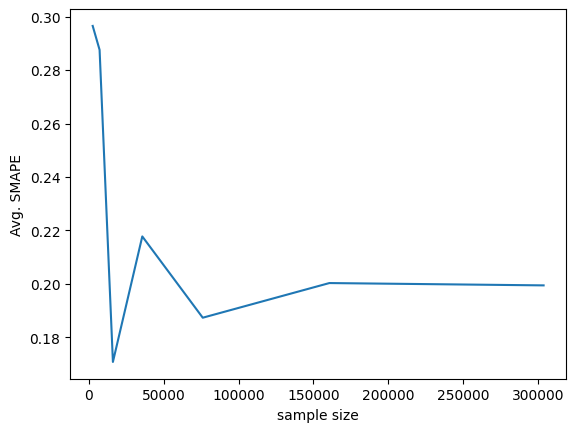

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()


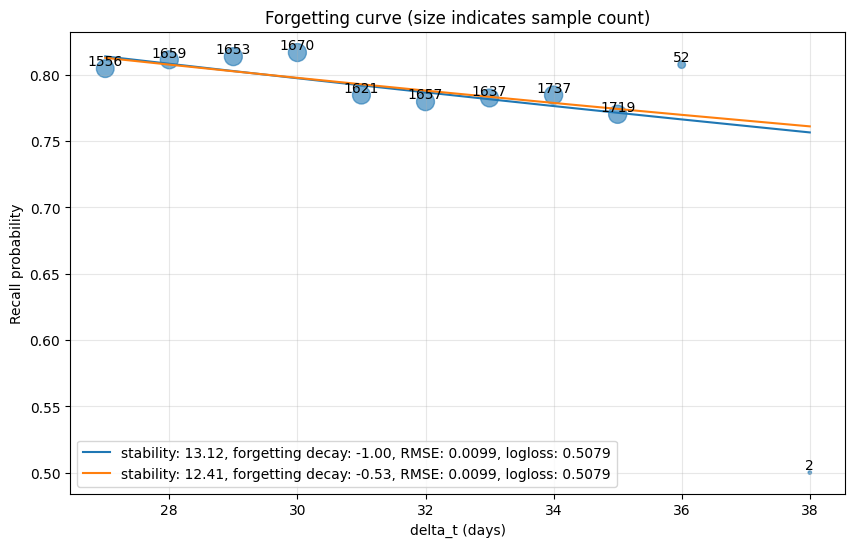

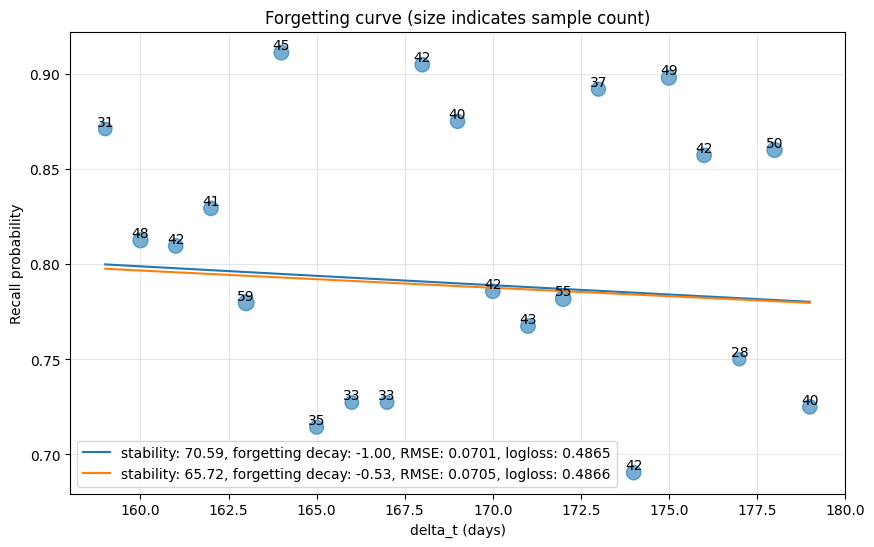

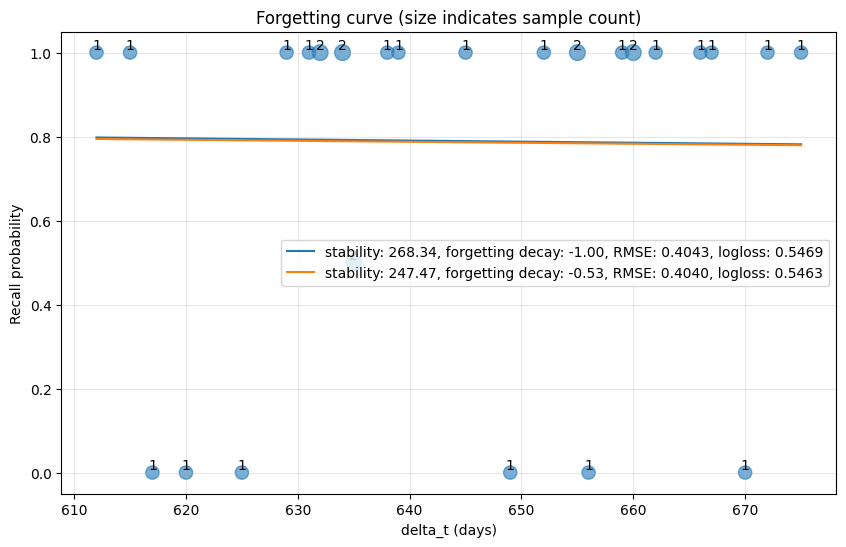

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = df[df["r_history"] == r_history]["t_history"].value_counts().index[0]
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(points.index, y_true, s=np.sqrt(points["count"] / sum(points["count"])) * 500, alpha=0.6)
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha='center', va='bottom')

    for s, d in zip(stabilities, [initial_parameters[19], trained_parameters[19]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(tmp["y"], power_forgetting_curve(tmp["delta_t"], s, -d), )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()